# Entropic estimation of optimal transport maps

We introduce and implement the paper *Entropic estimation of optimal transport maps* by
Aram-Alexandre Pooladian and Jonathan Niles-Weed (2022).


The goal of Optimal Transport is to minimize the quadratic cost of transportation between two probability distributions. Mathematically, we want to solve the so-called *Monge problem*:
\begin{align}
    \underset{T \in \mathcal{T}(P,Q)}{\min} \int \frac{1}{2} \Vert x - T(x)\Vert_2^2 \hspace{0.1cm}dP(x) \hspace{2cm}   (1)
\end{align}

with $P$ and $Q$ two probabilty measures on $\mathbb{R}^d$ and $\mathcal{T}(P,Q):= \big\{T: \mathbb{R}^d \xrightarrow[]{} \mathbb{R}^d, \hspace{0.2cm} P\circ T^{-1}  = Q \big\}$. We denote by $T_0$ the solution of $(1)$. To directly solve $(1)$, all the consistent approaches face computational issues. Notably to circumvent these computational issues, Cuturi (2013) proposed a regularized version of $(1)$:

\begin{align}
    \underset{\pi \in \Pi(P,Q)}{\inf} \int \int \frac{1}{2} \Vert x - y\Vert_2^2 \hspace{0.1cm}d\pi(x,y) + \epsilon D_{KL}\big(\pi \vert P\otimes Q \big) \hspace{2cm} (2)
\end{align}

with $\Pi(P,Q)$ the set of couplings between $P$ and $Q$ and $D_{KL}$ the
Kullback–Leibler divergence. The solution of $(2)$ has good computational and statistical properties in order to approximate $T_0$. Indeed, from a computational point of view, this regularized version can be solved with Sinkhorn algorithm in a quadratic time and this can be  parallelized. From a statistical point of view, this paper studies an estimator of $T_0$ based on $(2)$, the barycentric
projection of the optimal entropic plan, and studies its convergence rate, comparing it to known minimax rates.




In [1]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.1 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.geometry.costs import SqPNorm, SqEuclidean
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn, sinkhorn_lr
from ott.tools import plot

## Setting for this tutorial : 2-samples estimates

We consider the common case where $P$ and $Q$ are unknown and we only observe independent samples fom these distributions: $X_1,...,X_n \sim P$ and $Y_1,...,Y_n \sim Q$. In other words, we only have access to the empirical measures $P_n= \frac{1}{n} \sum_{i=1}^n \delta_{X_i}$ and $Q_n=\frac{1}{n} \sum_{i=1}^n \delta_{Y_i}$. We assume several regularity asssumptions on $T_0$. In particular, it's assumed that $\varphi_0$ is $\alpha$-Hölder with $\varphi_0$ such that $T_0 = \nabla \varphi_0$. It's known (from Hütter and Rigollet - 2021) that up to a logarithmic factor, the minimax rate for this estimation problem is $n^{-\frac{2\alpha}{2\alpha -2+d}}$. The ultimate goal would be to reach the minimax rate with an estimator based on $(2)$ and inheriting the good computational properties induced by $(2)$.

Given $\pi_\epsilon$ the solution of $(2)$, the barycentric projection is defined as,
\begin{align}
    T_\epsilon(x) = \int y d\pi_\epsilon^x(y) = \mathbb{E}_{\pi_\epsilon}\big[Y\vert X=x]
\end{align}
$T_\epsilon$ plays for $(2)$ the  same role as $T_0$ for $(1)$. The estimator $\hat{T}$ is the empirical  counterpart of $T_{\epsilon}$, replacing $P$ and $Q$ by $P_n$ and $Q_n$ (even if it's not clearly written, $\hat{T} = \hat{T}(n,\epsilon)$ obviously depends on $n$ and $\epsilon$).

So, the convergence rate proved in this paper is sligthly slower than the minimax rate but numerical experiments suggest that it can be improved up to the minimax rate. The  authors conjecture that this estimator (or a tuned version) reach the minimax rate. Even though  the current proved rate is sub-optimal, this estimator has good computational properties that make it interesting in practice.

We note that $\hat{T}$ also has an explicit formula:
$$\hat{T}_{\varepsilon,(n, n)}(x)=\frac{\frac{1}{n} \sum_{i=1}^n Y_i e^{\frac{1}{\varepsilon}\left(g_{\varepsilon,(n, n)}\left(Y_i\right)-\frac{1}{2}\left\|x-Y_i\right\|^2\right)}}{\frac{1}{n} \sum_{i=1}^n e^{\frac{1}{\varepsilon}\left(g_{\varepsilon,(n, n)}\left(Y_i\right)-\frac{1}{2}\left\|x-Y_i\right\|^2\right)}}$$
where $g_{\varepsilon,(n, n)}$ is the entropic potential corresponding to $Q_n$ in the optimal entropic plan between $P_n$ and $Q_n$, obtained by the ouput of Sinkhorn algorithm.

### Data generation

Source points are generated according to an unifornm law on $[-1,1]^2$. Target points are generated according to an unifornm law on $[-1,1]^2$ transformed by a map $T$.

In [3]:
def create_points(rng, n, d, T): # T must be a monotone scalar function !
    rngs = jax.random.split(rng, 2)

    x = jax.random.uniform(rngs[0], (n,d), minval = -1, maxval = 1)
    z = jax.random.uniform(rngs[1], (n,d), minval = -1, maxval = 1)

    y = T(z)

    return x, y

Create a {class}`~ott.problems.linear.linear_problem.LinearProblem` comparing two {class}`point clouds <ott.geometry.pointcloud.PointCloud>`.

In [38]:
def OT_sinkhorn_solved(x, y, alpha = 1, epsilon = None):

    alpha_bar = jnp.min(jnp.array([alpha, 3]))
    d_ = 2 * jnp.ceil(d/2)
    if epsilon == None : # epsilon optimaly chosen  according to `Pooladian and Niles-Weed, 2021`
        epsilon = n ** (- 1/(d_ + alpha_bar + 1))
        print("Chosen epsilon :", epsilon)

    geom = pointcloud.PointCloud(x, y, cost_fn = SqEuclidean() , epsilon = epsilon)
    ot_prob = linear_problem.LinearProblem(geom)
    solver = sinkhorn.Sinkhorn()
    ot_sink = solver(ot_prob)


    return ot_sink

Compute the corresponding {class}`~ott.problems.linear.potentials.DualPotentials` of the problem in order to have access to its `transport` method.

In [4]:
def entropic_map_estimator_TWO_sample(ot_sink):
    DualPotentials = ot_sink.to_dual_potentials()
    return DualPotentials.transport

In [6]:
rng = jax.random.PRNGKey(0)
T = lambda x : 3 * x**2 * jnp.sign(x) # jnp.log(1.2 + x) #
n = 1000
d = 2
alpha = 1

x,y = create_points(rng, n, d, T)
ot_sink = OT_sinkhorn_solved(x,y , alpha, epsilon = 0.01)


Comparison of the true map $T$ and the estimated map $\hat{T}_{\varepsilon,(n, n)}$ by ploting the image of the two functions of a a new dataset following $\mathcal{U}\sim[-1,1]^2$

[]

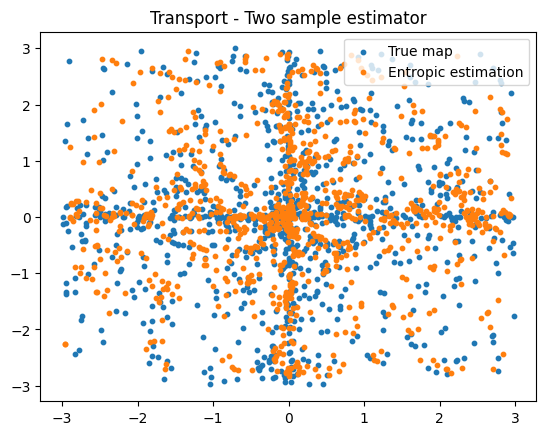

In [8]:
T_hat_2 = entropic_map_estimator_TWO_sample(ot_sink = ot_sink)

rng = jax.random.PRNGKey(1)
x_tilde, _ = create_points(rng, n, d, T)

y_tilde = T(x_tilde)
y_tilde_estimated_2 = T_hat_2(x_tilde)


plt.figure()
plt.plot()
plt.scatter(y_tilde[:,0], y_tilde[:,1], s = 10, label = "True map")
plt.scatter(y_tilde_estimated_2[:,0], y_tilde_estimated_2[:,1], s = 10, label = "Entropic estimation")
plt.title("Transport - Two sample estimator")
plt.legend(loc='upper right')
plt.plot()


### Convergence bound

It's shown that up to a logarithmic factor, the convergence rate of this estimator is of order $n^{-\frac{(\alpha_{m}+1)}{2(d' +\alpha_{m} +1)}}$ with $\alpha_{m} = \min(\alpha,3)$ and $d' = 2 \left \lceil{\frac{d}{2}}\right \rceil$.




In [9]:
def entropic_map_mse(rng, n_, T_hat, T):
    X_ = jax.random.uniform(rng, (n_,d), minval = -1, maxval = 1)
    return n_**(-1) * jnp.sum((T_hat(X_) - T(X_))**2)

In [10]:
def bound(alpha, d):
    alpha_bar = jnp.min(jnp.array([alpha, 3]))
    d_ = 2 * jnp.ceil(d/2)

    bound_fn = lambda n: n**(- (alpha_bar+1)/(2*(d_+alpha_bar+1))) * jnp.log(n)

    return bound_fn

def minimax_bound(alpha,d):
    bound_fn = lambda n: n**(-2*alpha/(2*alpha -2 +d))
    return bound_fn

In [11]:
rng = jax.random.PRNGKey(2)
rngs = jax.random.split(rng, 2)
N = 10000

n_stacked = [100, 500, 1000, 2000, 5000, 10000]

mse_stacked = []
for k in n_stacked :
    x,y = create_points(rngs[0], n, d, T)
    ot_sink = OT_sinkhorn_solved(x, y, alpha, epsilon = None)
    T_hat = entropic_map_estimator_TWO_sample(ot_sink = ot_sink)
    mse = entropic_map_mse(rngs[1], N, T_hat, T)

    mse_stacked.append(mse)

bound_fn = bound(alpha, d)
bound_minimax_fn = minimax_bound(alpha, d)


minimax_bound_evaluations = [bound_minimax_fn(j) for j in n_stacked]
bound_evaluations = [bound_fn(j).item() for j in n_stacked]

Chosen epsilon : 0.17782794
Chosen epsilon : 0.17782794
Chosen epsilon : 0.17782794
Chosen epsilon : 0.17782794
Chosen epsilon : 0.17782794
Chosen epsilon : 0.17782794


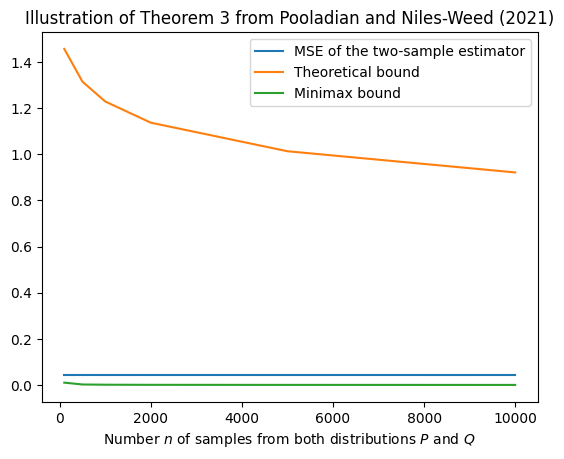

In [12]:
plt.figure()
plt.plot(n_stacked, mse_stacked, label = "MSE of the two-sample estimator")
plt.plot(n_stacked, bound_evaluations , label = "Theoretical bound")
plt.plot(n_stacked, minimax_bound_evaluations , label = "Minimax bound")
plt.legend()
plt.title("Illustration of Theorem 3 from Pooladian and Niles-Weed (2021)")
plt.xlabel("Number $n$ of samples from both distributions $P$ and $Q$")
plt.show()

## Application to real dataset
We are given 1000 images from the MNIST and USPS datasets (datasets containing handwritten digits, but with slightly different styles), without annotations.

The goal is to estimate the map that transports the images from MNIST to those of USPS.

In [66]:
import torchvision.datasets as datasets
import torchvision
import torch


In [67]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True)
mnist_data = mnist_trainset.data
mnist_labels = jnp.array(mnist_trainset.targets)

transform = torchvision.transforms.Resize((16,16))
mnist_data_resize = jnp.array(transform(mnist_data))
mnist_data_final = jnp.array([elt.reshape(16*16).astype(float)/255.0 for elt in mnist_data_resize])

In [68]:
usps_trainset = datasets.USPS(root='./data', train=True, download=True, transform=None)

usps_data = jnp.array(usps_trainset.data)
usps_labels = jnp.array(usps_trainset.targets)
usps_data_final = jnp.array([elt.reshape(16*16).astype(float)/255.0 for elt in usps_data])

In [69]:
n_train = 1000 # should be <= 7291 (because of USPS dataset size)

x_train = mnist_data_final[:n_train, :]
y_train = usps_data_final[:n_train, :]

x_test = mnist_data_final[n_train:, :]
x_test_labels = mnist_labels[n_train:]

In [70]:
ot_mnist = OT_sinkhorn_solved(x_train, y_train , epsilon = 0.1)
T_hat = entropic_map_estimator_TWO_sample(ot_sink = ot_mnist)

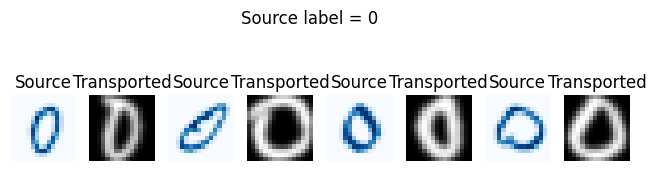

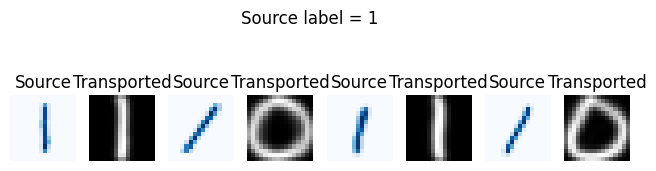

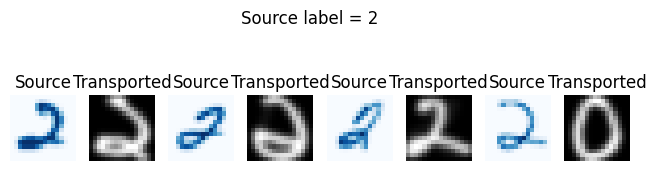

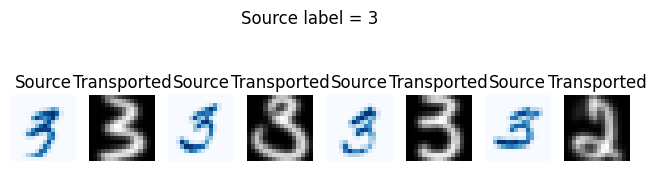

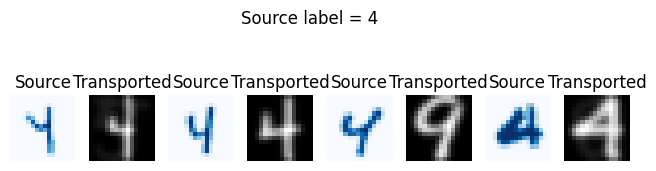

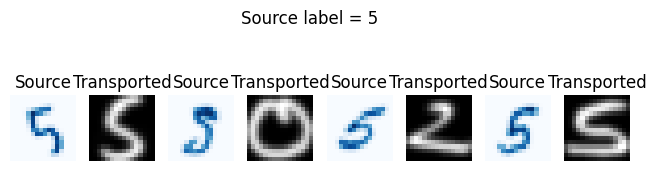

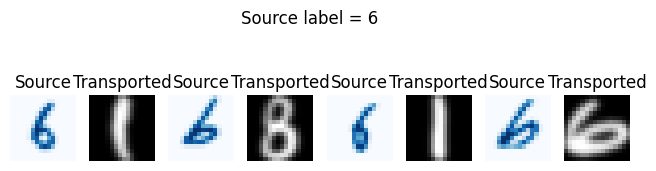

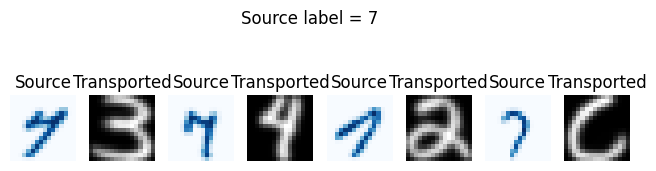

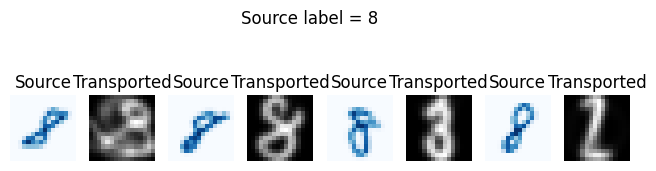

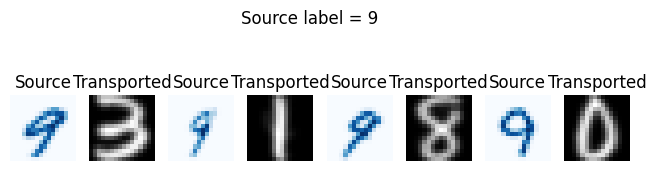

In [71]:
n_samples = 4
for label in jnp.arange(10) :
  count = 0
  i=0

  while count < n_samples :
    if x_test_labels[i] == label:

      if count == 0:
          fig, axes = plt.subplots(1, 2*n_samples, figsize=(n_samples * 2, 2))
          fig.suptitle(f"Source label = {label}", y=1.05)
          plt.subplots_adjust(top=0.8)

      axes[2*count].imshow(x_test[i, :].reshape(16, 16), cmap='Blues')
      axes[2*count].set_title(f"Source")
      axes[2*count].axis('off')

      axes[2*count+1].imshow(T_hat(x_test[i, :]).reshape(16, 16), cmap='gray')
      axes[2*count+1].set_title(f"Transported")
      axes[2*count+1].axis('off')
      count += 1

      i += 1

    else :
      i += 1


First, we observe that the image under $\hat{T}$ of almost all test images generates handwritten digits similar to those of USPS.

However, we notice that each digit from MNIST does not necessarily map to the same digit in the USPS style. In particular, the results vary depending on the input digit. For example, all `0` digits still produce `0` digits. For `2`, `3`, and `4`, three out of four produce the corresponding digit. Finally, for `7` and `9`, the results are not good at all`